<a href="https://colab.research.google.com/github/Rory59582067/COM6102_Project/blob/main/6003Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background & Objective


This data set is populated by capturing user ratings from Google reviews. Reviews on attractions from 24 categories across Europe are considered. Google user rating ranges from 1 to 5 and average user rating per category is calculated.

Data link: <https://archive.ics.uci.edu/dataset/485/tarvel+review+ratings>

**Problem outline:** create a complete neural network model to predict overall ratings based on the various place ratings, include feature engineering and hyperparameter tuning.

Target column: Overall rating

# Data collection


In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
travel_review_ratings = fetch_ucirepo(id=485)

In [ ]:
# data (as pandas dataframes)
df = travel_review_ratings.data.features

In [ ]:
df.head()

,churches,resorts,beaches,parks,theatres,museums,malls,zoos,restaurants,pubs/bars,...,dance clubs,swimming pools,gyms,bakeries,beauty & spas,cafes,view points,monuments,gardens,overall_rating
0,0.0,0.0,3.63,3.65,5.0,2.92,5.0,2.35,2.33,2.64,...,0.59,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,1.569167
1,0.0,0.0,3.63,3.65,5.0,2.92,5.0,2.64,2.33,2.65,...,0.59,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,1.581667
2,0.0,0.0,3.63,3.63,5.0,2.92,5.0,2.64,2.33,2.64,...,0.59,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,1.580417
3,0.0,0.5,3.63,3.63,5.0,2.92,5.0,2.35,2.33,2.64,...,0.59,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,1.590417
4,0.0,0.0,3.63,3.63,5.0,2.92,5.0,2.64,2.33,2.64,...,0.59,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,1.580417


# Data preprocessing and evaluation

In [ ]:
import pandas as pd

In [ ]:
# Convert object to numeric
df = df.apply(pd.to_numeric, errors='coerce')

In [ ]:
# Create overall_rating column (target variable) - average of all ratings
rating_columns = df.columns
df['overall_rating'] = df[rating_columns].mean(axis=1)

In [ ]:
# Check
df.dtypes

,0
churches,float64
resorts,float64
beaches,float64
parks,float64
theatres,float64
museums,float64
malls,float64
zoos,float64
restaurants,float64
pubs/bars,float64


# Feature engineering

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
# Create additional features
# Popular categories ratio
df['popular_places_rating'] = df[['restaurants',
                                  'malls',
                                  'parks']].mean(axis=1)


In [ ]:
# Entertainment rating
df['entertainment_rating'] = df[['theatres',
                                'museums',
                                'dance clubs']].mean(axis=1)

In [ ]:
# Food rating
df['food_rating'] = df[['restaurants',
                         'burger/pizza shops',
                         'cafes',
                         'bakeries']].mean(axis=1)


In [ ]:
#Outdoors rating
df['outdoors_rating'] = df[['beaches',
                           'parks',
                           'gardens',
                           'view points']].mean(axis=1)

In [ ]:
# Cultural rating
df['cultural_rating'] = df[['museums',
                           'art galleries',
                           'monuments',
                           'churches']].mean(axis=1)

In [ ]:
# Check for missing values and handle them
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
churches                 0
resorts                  0
beaches                  0
parks                    0
theatres                 0
museums                  0
malls                    0
zoos                     0
restaurants              0
pubs/bars                0
local services           1
burger/pizza shops       1
hotels/other lodgings    0
juice bars               0
art galleries            0
dance clubs              0
swimming pools           0
gyms                     0
bakeries                 0
beauty & spas            0
cafes                    0
view points              0
monuments                0
gardens                  1
overall_rating           0
popular_places_rating    0
entertainment_rating     0
food_rating              0
outdoors_rating          0
cultural_rating          0
dtype: int64


In [ ]:
# Fill missing values with the mean of each column
df = df.fillna(df.mean())

In [ ]:
# Prepare the data
X = df.drop(['overall_rating'], axis=1)
y = df['overall_rating']

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model building and hyperparameters tuning

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 18.4 MB/s eta 0:00:00


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import optuna
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Create a preprocessor pipeline
preprocessor = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(f_regression, k=20))
])

In [ ]:
# Correctly fit and transform the training data
X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)  # Note: passing y_train here
X_test_preprocessed = preprocessor.transform(X_test)

In [ ]:
# Get feature names after selection for later visualization
feature_selector = preprocessor.named_steps['feature_selection']
selected_features = X.columns[feature_selector.get_support()]
feature_scores = feature_selector.scores_

In [ ]:
# Define the neural network model builder function
def create_model(neurons=64, hidden_layers=2, activation='relu',
                 dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()

    # Input layer
    model.add(Dense(neurons, input_dim=X_train_preprocessed.shape[1], activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # Hidden layers
    for _ in range(hidden_layers - 1):
        model.add(Dense(neurons, activation=activation))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation='linear'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

In [ ]:
# Define Optuna objective function for hyperparameter optimization
def objective(trial):
    # Suggest hyperparameters
    neurons = trial.suggest_categorical('neurons', [32, 64, 128, 256])
    hidden_layers = trial.suggest_int('hidden_layers', 1, 3)
    activation = trial.suggest_categorical('activation', ['relu', 'elu'])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.4)
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.01, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])

    # Create and train model
    model = create_model(
        neurons=neurons,
        hidden_layers=hidden_layers,
        activation=activation,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate
    )

    # Train model
    history = model.fit(
        X_train_preprocessed, y_train,
        epochs=50,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )

    # Return the validation loss
    val_loss = min(history.history['val_loss'])
    return val_loss

In [ ]:
# Create the Optuna study and run optimization
print("Starting Optuna hyperparameter optimization...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20, show_progress_bar=True)

[I 2025-03-29 06:39:24,270] A new study created in memory with name: no-name-b1e8e772-cb1f-4803-a009-e376e644799f


Starting Optuna hyperparameter optimization...


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 22.
[I 2025-03-29 06:39:40,105] Trial 0 finished with value: 0.005311643239110708 and parameters: {'neurons': 256, 'hidden_layers': 3, 'activation': 'elu', 'dropout_rate': 0.11719947477466533, 'learning_rate': 0.008479342988989988, 'batch_size': 128}. Best is trial 0 with value: 0.005311643239110708.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 46.
[I 2025-03-29 06:39:55,646] Trial 1 finished with value: 0.005223758518695831 and parameters: {'neurons': 128, 'hidden_layers': 2, 'activation': 'elu', 'dropout_rate': 0.15701885082454206, 'learning_rate': 0.0018517630938387382, 'batch_size': 128}. Best is trial 1 with value: 0.005223758518695831.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 21.
[I 2025-03-29 06:40:31,810] Trial 2 finished with value: 0.004572991281747818 and parameters: {'neurons': 128, 'hidden_layers': 3, 'activation': 'relu', 'dropout_rate': 0.35703553954336453, 'learning_rate': 0.003975605447596445, 'batch_size': 16}. Best is trial 2 with value: 0.004572991281747818.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 49.
[I 2025-03-29 06:40:44,289] Trial 3 finished with value: 0.004999944008886814 and parameters: {'neurons': 128, 'hidden_layers': 1, 'activation': 'relu', 'dropout_rate': 0.27919957616502655, 'learning_rate': 0.0014993833432655037, 'batch_size': 128}. Best is trial 2 with value: 0.004572991281747818.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 50.
[I 2025-03-29 06:41:03,323] Trial 4 finished with value: 0.057730793952941895 and parameters: {'neurons': 32, 'hidden_layers': 3, 'activation': 'relu', 'dropout_rate': 0.13345868732933425, 'learning_rate': 0.00013861920650551856, 'batch_size': 64}. Best is trial 2 with value: 0.004572991281747818.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 21.
[I 2025-03-29 06:41:25,130] Trial 5 finished with value: 0.005112874321639538 and parameters: {'neurons': 64, 'hidden_layers': 3, 'activation': 'relu', 'dropout_rate': 0.37182746144771195, 'learning_rate': 0.006345573509004579, 'batch_size': 32}. Best is trial 2 with value: 0.004572991281747818.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 49.
[I 2025-03-29 06:42:01,210] Trial 6 finished with value: 0.004987736698240042 and parameters: {'neurons': 128, 'hidden_layers': 1, 'activation': 'relu', 'dropout_rate': 0.34502686213492473, 'learning_rate': 0.00021444411354000934, 'batch_size': 16}. Best is trial 2 with value: 0.004572991281747818.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 49.
[I 2025-03-29 06:42:27,504] Trial 7 finished with value: 0.01742306910455227 and parameters: {'neurons': 32, 'hidden_layers': 1, 'activation': 'elu', 'dropout_rate': 0.21092515594007544, 'learning_rate': 0.00016191679920328419, 'batch_size': 32}. Best is trial 2 with value: 0.004572991281747818.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 49: early stopping
Restoring model weights from the end of the best epoch: 39.
[I 2025-03-29 06:43:03,382] Trial 8 finished with value: 0.0047581433318555355 and parameters: {'neurons': 32, 'hidden_layers': 1, 'activation': 'elu', 'dropout_rate': 0.387442705378353, 'learning_rate': 0.004062855795183759, 'batch_size': 16}. Best is trial 2 with value: 0.004572991281747818.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 44.
[I 2025-03-29 06:43:18,826] Trial 9 finished with value: 0.007029795087873936 and parameters: {'neurons': 128, 'hidden_layers': 2, 'activation': 'relu', 'dropout_rate': 0.21993696028886328, 'learning_rate': 0.0007800446211370153, 'batch_size': 128}. Best is trial 2 with value: 0.004572991281747818.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 48.
[I 2025-03-29 06:44:12,883] Trial 10 finished with value: 0.004896706435829401 and parameters: {'neurons': 64, 'hidden_layers': 3, 'activation': 'relu', 'dropout_rate': 0.31489386462923985, 'learning_rate': 0.0005249580648148483, 'batch_size': 16}. Best is trial 2 with value: 0.004572991281747818.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 16.
[I 2025-03-29 06:44:36,427] Trial 11 finished with value: 0.005504555068910122 and parameters: {'neurons': 32, 'hidden_layers': 2, 'activation': 'elu', 'dropout_rate': 0.3949964509297153, 'learning_rate': 0.0035118243814327497, 'batch_size': 16}. Best is trial 2 with value: 0.004572991281747818.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 22.
[I 2025-03-29 06:45:00,539] Trial 12 finished with value: 0.005186855792999268 and parameters: {'neurons': 256, 'hidden_layers': 1, 'activation': 'elu', 'dropout_rate': 0.3141808868337603, 'learning_rate': 0.0032631515009957945, 'batch_size': 16}. Best is trial 2 with value: 0.004572991281747818.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 45.
[I 2025-03-29 06:45:43,752] Trial 13 finished with value: 0.004973133094608784 and parameters: {'neurons': 32, 'hidden_layers': 2, 'activation': 'elu', 'dropout_rate': 0.35326845410806157, 'learning_rate': 0.0034601254640423966, 'batch_size': 16}. Best is trial 2 with value: 0.004572991281747818.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 44: early stopping
Restoring model weights from the end of the best epoch: 34.
[I 2025-03-29 06:45:59,685] Trial 14 finished with value: 0.004624299239367247 and parameters: {'neurons': 128, 'hidden_layers': 2, 'activation': 'relu', 'dropout_rate': 0.3923450186783405, 'learning_rate': 0.00522375849490789, 'batch_size': 64}. Best is trial 2 with value: 0.004572991281747818.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 10.
[I 2025-03-29 06:46:08,645] Trial 15 finished with value: 0.004857704974710941 and parameters: {'neurons': 128, 'hidden_layers': 2, 'activation': 'relu', 'dropout_rate': 0.2732304663914302, 'learning_rate': 0.009987586167384606, 'batch_size': 64}. Best is trial 2 with value: 0.004572991281747818.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 47.
[I 2025-03-29 06:46:28,854] Trial 16 finished with value: 0.00469884742051363 and parameters: {'neurons': 128, 'hidden_layers': 3, 'activation': 'relu', 'dropout_rate': 0.3249480741883769, 'learning_rate': 0.0015108799607928456, 'batch_size': 64}. Best is trial 2 with value: 0.004572991281747818.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 48.
[I 2025-03-29 06:46:47,211] Trial 17 finished with value: 0.015411078929901123 and parameters: {'neurons': 128, 'hidden_layers': 2, 'activation': 'relu', 'dropout_rate': 0.3984672701057813, 'learning_rate': 0.00040707762604572025, 'batch_size': 64}. Best is trial 2 with value: 0.004572991281747818.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 38: early stopping
Restoring model weights from the end of the best epoch: 28.
[I 2025-03-29 06:47:04,109] Trial 18 finished with value: 0.004505644552409649 and parameters: {'neurons': 128, 'hidden_layers': 3, 'activation': 'relu', 'dropout_rate': 0.28087842586028416, 'learning_rate': 0.006105821761272673, 'batch_size': 64}. Best is trial 18 with value: 0.004505644552409649.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 48: early stopping
Restoring model weights from the end of the best epoch: 38.
[I 2025-03-29 06:47:34,135] Trial 19 finished with value: 0.004878669045865536 and parameters: {'neurons': 64, 'hidden_layers': 3, 'activation': 'relu', 'dropout_rate': 0.2334510589341405, 'learning_rate': 0.0023135072254432563, 'batch_size': 32}. Best is trial 18 with value: 0.004505644552409649.


In [ ]:
# Print best hyperparameters
print("\nBest trial:")
trial = study.best_trial
print(f"  Value (validation loss): {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


Best trial:
  Value (validation loss): 0.004505644552409649
  Params: 
    neurons: 128
    hidden_layers: 3
    activation: relu
    dropout_rate: 0.28087842586028416
    learning_rate: 0.006105821761272673
    batch_size: 64


In [ ]:
# Create final model with best hyperparameters
best_params = study.best_params
print("\nTraining final model with best hyperparameters...")
final_model = create_model(
    neurons=best_params['neurons'],
    hidden_layers=best_params['hidden_layers'],
    activation=best_params['activation'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)


Training final model with best hyperparameters...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train final model
history = final_model.fit(
    X_train_preprocessed, y_train,
    epochs=50,
    batch_size=best_params['batch_size'],
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.2058 - mae: 1.3905 - val_loss: 0.0537 - val_mae: 0.1848
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3630 - mae: 0.4606 - val_loss: 0.0250 - val_mae: 0.1284
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2029 - mae: 0.3433 - val_loss: 0.0402 - val_mae: 0.1644
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1413 - mae: 0.2855 - val_loss: 0.0182 - val_mae: 0.1101
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0962 - mae: 0.2396 - val_loss: 0.0114 - val_mae: 0.0862
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0750 - mae: 0.2129 - val_loss: 0.0158 - val_mae: 0.1015
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0575 - mae: 0.1889 - val_loss: 0.0107 - val_mae: 0.0822
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0575 - mae: 0.1855 - val_loss: 0.0125 - val_mae: 0.0894
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0490 - mae: 

# Model evaluation

In [ ]:
# Evaluate final model
y_pred = final_model.predict(X_test_preprocessed)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nFinal model performance on test set:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Final model performance on test set:
Mean Squared Error: 0.0047
Root Mean Squared Error: 0.0685
R-squared: 0.9231


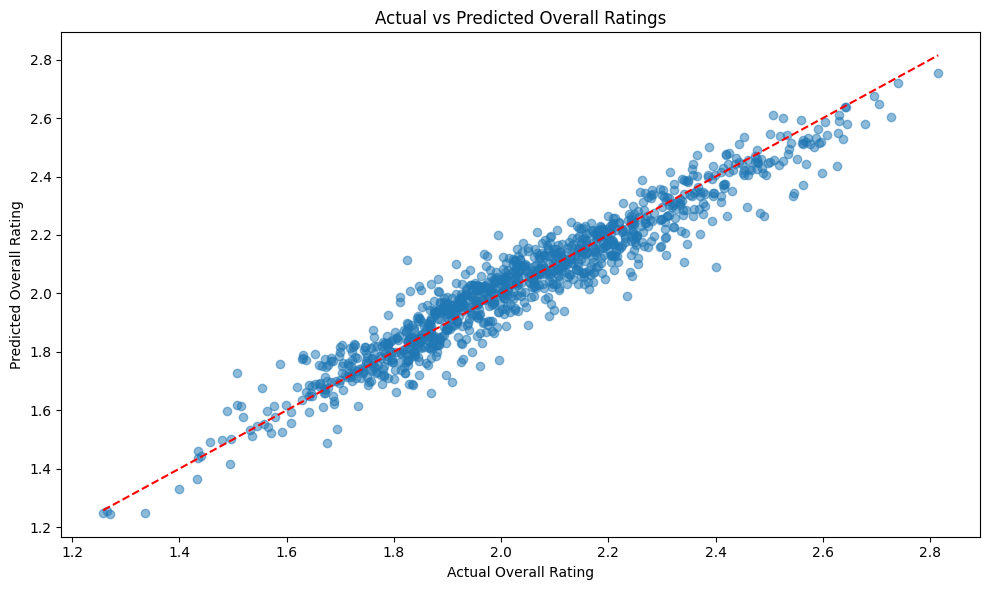

In [ ]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Overall Rating')
plt.ylabel('Predicted Overall Rating')
plt.title('Actual vs Predicted Overall Ratings')
plt.tight_layout()
plt.savefig('predictions_vs_actual.png')
plt.show()

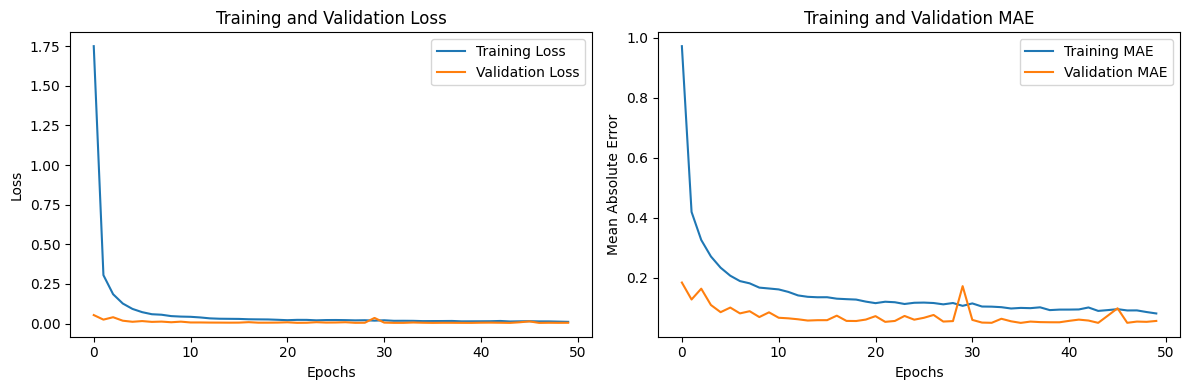

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')
plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

In [ ]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Score': feature_scores
})
feature_importance = feature_importance.sort_values(by='Score', ascending=False)

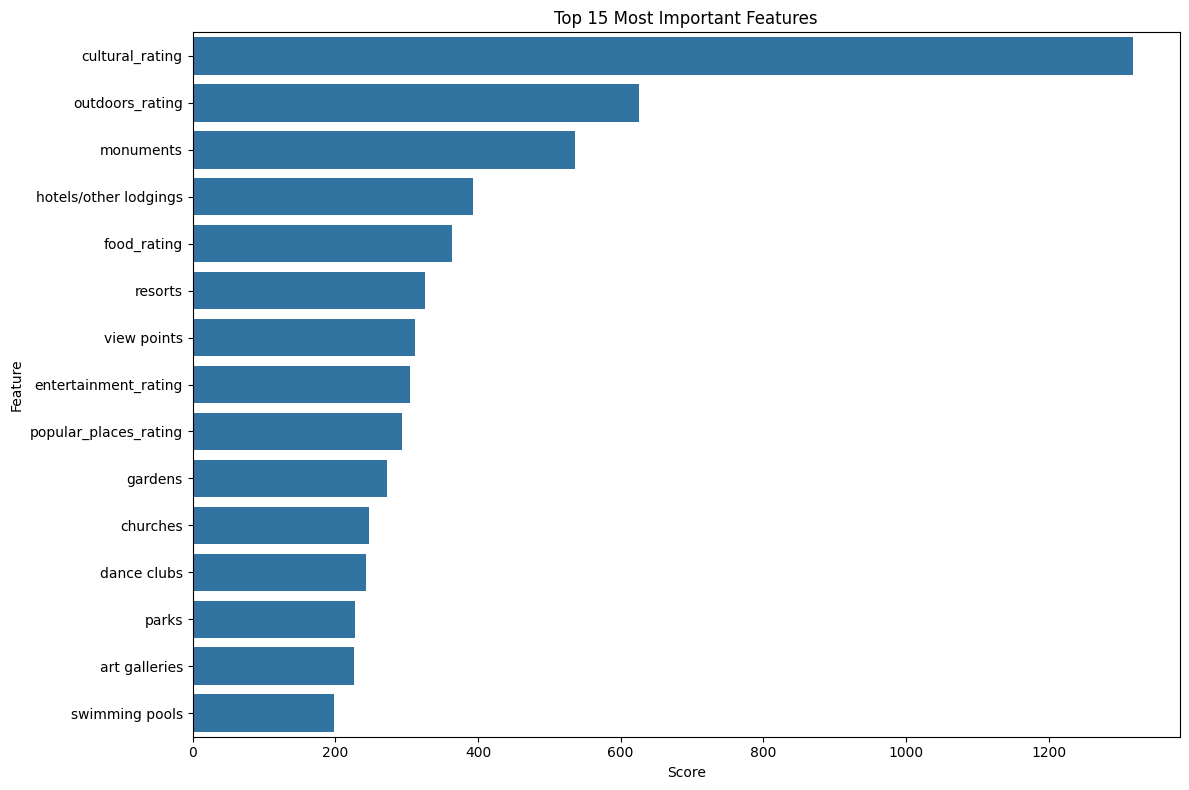

In [ ]:
# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

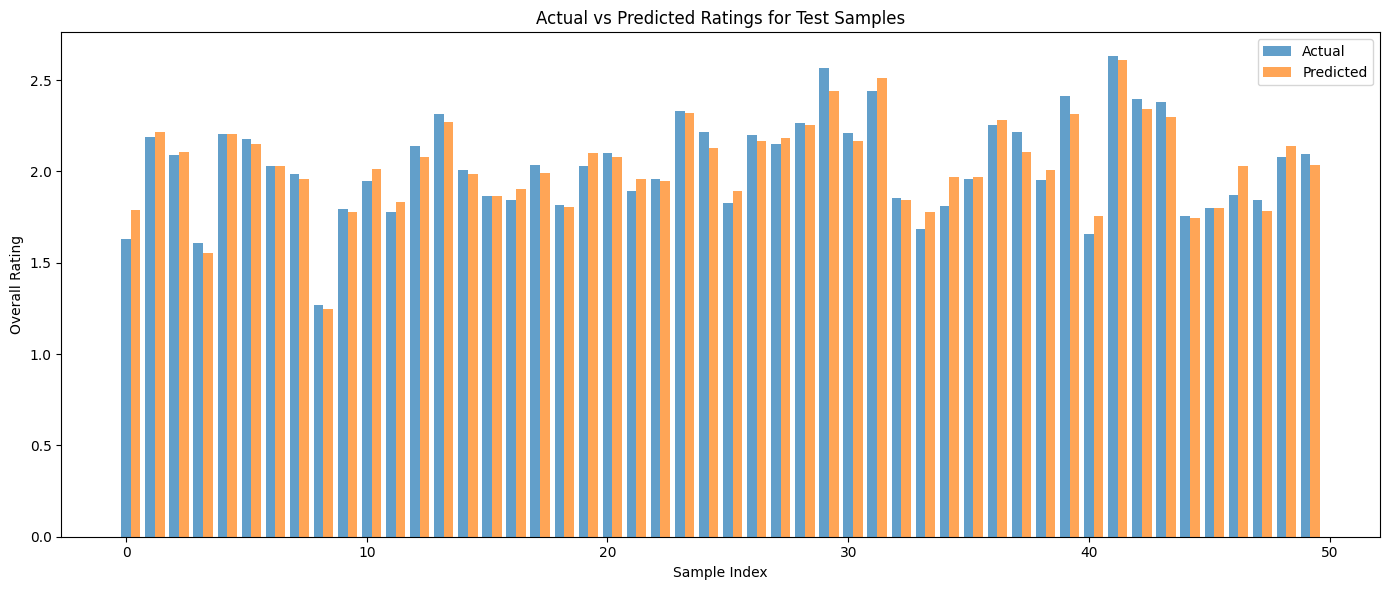

In [ ]:
# Plot actual vs predicted for top 50 test samples
plt.figure(figsize=(14, 6))
n_samples = min(50, len(y_test))
indices = np.arange(n_samples)
plt.bar(indices, y_test.iloc[:n_samples], width=0.4, label='Actual', alpha=0.7)
plt.bar(indices + 0.4, y_pred.flatten()[:n_samples], width=0.4, label='Predicted', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Overall Rating')
plt.title('Actual vs Predicted Ratings for Test Samples')
plt.legend()
plt.tight_layout()
plt.savefig('actual_vs_predicted_samples.png')
plt.show()

In [ ]:
# Save the preprocessor and model for future use
import joblib
from tensorflow.keras.models import save_model

In [ ]:
# Save preprocessor
joblib.dump(preprocessor, 'rating_preprocessor.pkl')

['rating_preprocessor.pkl']

In [ ]:
# Save keras model
save_model(final_model, 'rating_model.h5')

print("\nPreprocessor and model saved successfully!")


Preprocessor and model saved successfully!
